<a href="https://colab.research.google.com/github/PavelTertychnyi/Algo-project/blob/master/VAE_flickr30k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 9.3MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchtext import data
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

import cv2

import re
import pandas as pd
import numpy as np
import time

import os
from random import randint
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import Image, display

from tqdm import tqdm_notebook

from google.colab import files

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Download data

In [0]:
# Download dataset
flickr30k_images = "https://drive.google.com/open?id=1Uh_ueCInolT-PhgXjTRZ2_JBfeuqhfQ0"
fluff, id = flickr30k_images.split('=')

In [0]:
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('flickr30k_images.zip') 

In [5]:
!unzip "flickr30k_images"

Archive:  flickr30k_images.zip
   creating: flickr30k_images/
   creating: flickr30k_images/flickr30k_images/
  inflating: flickr30k_images/flickr30k_images/2230458748.jpg  
  inflating: flickr30k_images/flickr30k_images/3131519555.jpg  
  inflating: flickr30k_images/flickr30k_images/4725077313.jpg  
  inflating: flickr30k_images/flickr30k_images/4483334217.jpg  
  inflating: flickr30k_images/flickr30k_images/3577235421.jpg  
  inflating: flickr30k_images/flickr30k_images/334167474.jpg  
  inflating: flickr30k_images/flickr30k_images/7579008108.jpg  
  inflating: flickr30k_images/flickr30k_images/2054125670.jpg  
  inflating: flickr30k_images/flickr30k_images/1260501563.jpg  
  inflating: flickr30k_images/flickr30k_images/18865365.jpg  
  inflating: flickr30k_images/flickr30k_images/942399470.jpg  
  inflating: flickr30k_images/flickr30k_images/537532165.jpg  
  inflating: flickr30k_images/flickr30k_images/374176648.jpg  
  inflating: flickr30k_images/flickr30k_images/485921585.jpg  
 

In [0]:
del downloaded

In [0]:
folder_name = r"flickr30k_images"

In [0]:
captions = pd.read_csv(os.path.join(folder_name, 'results.csv'), sep='|')

In [0]:
img_names = captions.image_name.unique()

In [0]:
train_img_names = img_names[:27000]
test_img_names = img_names[27000:]

## Prepare images

In [0]:
def gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

In [0]:
# Convert images to gray scale
image_description = {}
for name in img_names:
    image_description[name] = gray(cv2.imread(os.path.join(folder_name, 'flickr30k_images', name)))

## Data loader

In [0]:
class LoadData(Dataset):
    def __init__(self, names, images):
        self.transform = transforms.Compose([
          transforms.ToPILImage(),
          transforms.RandomCrop(size=(500, 500), pad_if_needed=True, fill=0),
          transforms.ToTensor()])

        self.names = names
        self.images = images

        self.max_len = 50

    def __getitem__(self, index):
      
        image = self.images[self.names[index]]
        image = self.transform(image)

        return image

    def __len__(self):
		    return len(self.names)

In [0]:
batch_size = 64

In [0]:
train_data_loader = LoadData(train_img_names, image_description)
train_data_iterator = DataLoader(train_data_loader, batch_size=batch_size)

In [0]:
test_data_loader = LoadData(test_img_names, image_description)
test_data_iterator = DataLoader(test_data_loader, batch_size=batch_size)

## Train

In [0]:
SEED = 1
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
class UnFlatten(nn.Module):
    def forward(self, input, size=(128, 7, 7)):
        return input.view(input.size(0), *size)

In [0]:
class VAE(nn.Module):
    def __init__(self, image_channels, img_h_dim, z_dim):
        super(VAE, self).__init__()

        # encoder
        self.conv1 = nn.Conv2d(image_channels, 32, kernel_size=4, stride=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.pool_size1 = None

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.pool_size2 = None

        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.pool_size3 = None

        self.flatten = Flatten()

        self.img_size = 128 * 7 * 7
        self.fc_enc = nn.Linear(self.img_size, img_h_dim)

        # bottleneck
        self.fc1 = nn.Linear(img_h_dim, z_dim)
        self.fc2 = nn.Linear(img_h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, self.img_size)

        # decoder
        self.unflatten = UnFlatten()

        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2)
        self.uppool1 = nn.MaxUnpool2d(2, stride=2)

        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2)
        self.uppool2 = nn.MaxUnpool2d(2, stride=2)

        self.deconv3 = nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2)
        self.uppool3 = nn.MaxUnpool2d(2, stride=2)

        self.sigm = nn.Sigmoid()

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z

    def bottleneck(self, img_h_dim):
        mu, logvar = self.fc1(img_h_dim), self.fc2(img_h_dim)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):

        out = F.relu(self.conv1(x))
        #out = F.dropout2d(out, p=0.5)
        if self.pool_size1 is None:
            self.pool_size1 = out.size()[2:]

        out, self.indices1 = self.pool1(out)
        #out = self.pool1(out)

        out = F.relu(self.conv2(out))
        #out = F.dropout2d(out, p=0.5)
        if self.pool_size2 is None:
            self.pool_size2 = out.size()[2:]

        out, self.indices2 = self.pool2(out)
        #out = self.pool2(out)

        out = F.relu(self.conv3(out))
        #out = F.dropout2d(out, p=0.5)
        if self.pool_size3 is None:
            self.pool_size3 = out.size()[2:]
            
        out, self.indices3 = self.pool3(out)
        #out = self.pool3(out)
        
        out = self.flatten(out)
        h = self.fc_enc(out)

        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        out = self.fc3(z)
        out = self.unflatten(out, size=(128, 7, 7))

        if self.indices3 is None:
            out = F.upsample(out, size=self.pool_size3, mode='nearest')
        else:
            out = self.uppool1(out, self.indices3, output_size=self.pool_size3)
        out = F.relu(self.deconv1(out))
        #out = F.dropout2d(out, p=0.5)
        
        if self.indices2 is None:
            out = F.upsample(out, size=self.pool_size2, mode='nearest')
        else:
            out = self.uppool2(out, self.indices2, output_size=self.pool_size2)
        out = F.relu(self.deconv2(out))
        #out = F.dropout2d(out, p=0.5)

        if self.indices1 is None:
            out = F.upsample(out, size=self.pool_size1, mode='nearest')
        else:
            out = self.uppool3(out, self.indices1, output_size=self.pool_size1)
        out = F.relu(self.deconv3(out))
        #out = F.dropout2d(out, p=0.5)

        out = self.sigm(out)

        self.indices1 = None
        self.indices2 = None
        self.indices3 = None

        return out

    def forward(self, image):
        z, mu, logvar = self.encode(image)
        z = self.decode(z)
        return z, mu, logvar

In [0]:
def loss_fn(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, size_average=False)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD, MSE, KLD

In [0]:
def rec_loss_fn(recon_x, x):
    MSE = F.mse_loss(recon_x, x, size_average=False)
    return MSE

In [0]:
h_dim = 1000
image_channels = 1
z_dim = 500

In [0]:
# to free GPU memory if needed
import gc
gc.collect()
torch.cuda.empty_cache()

In [25]:
model = VAE(image_channels=image_channels,
                    img_h_dim=h_dim,
                    z_dim=z_dim,
                   ).to(device)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform(m.weight.data)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

model.apply(weights_init)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


VAE(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (fc_enc): Linear(in_features=6272, out_features=1000, bias=True)
  (fc1): Linear(in_features=1000, out_features=500, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=6272, bias=True)
  (unflatten): UnFlatten()
  (deconv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
  (uppool1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
  (uppool2): MaxUnpool2d(ke

In [26]:
model.load_state_dict(torch.load('pretrained_not_cond_flickr30k_500zdim_vae_80_epoch_v3.torch'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [0]:
epochs = 20

In [28]:
model.train()
for epoch in range(epochs):
    total_loss = 0
    total_bce = 0
    total_kld = 0
    print("Epoch #{}".format(epoch))
    batch_idx = 0
    for images in train_data_iterator:
        images = images.cuda()
        recon_images, mu, logvar = model(images)
        loss = rec_loss_fn(recon_images, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #to_print = "Epoch[{}/{}] Batch: {} Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
        #                        epochs, batch_idx, loss.item() / batch_size, bce.item() / batch_size, kld.item() / batch_size)
        #print(to_print)
        batch_idx += 1
        total_loss += loss.item() / len(train_data_iterator)
    print(total_loss)

Epoch #0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


1893695.2440758278
Epoch #1
1841159.2553317533
Epoch #2
1836176.169727488
Epoch #3
1835611.327606635
Epoch #4
1833414.5198459711
Epoch #5
1831687.8335308053
Epoch #6
1830342.206457346
Epoch #7
1829437.765402843
Epoch #8
1828744.4238744078
Epoch #9
1828840.7514810432
Epoch #10
1828242.9197274873
Epoch #11
1828003.4377962078
Epoch #12
1827679.5219194316
Epoch #13
1826941.29443128
Epoch #14
1826529.381812795
Epoch #15
1826330.7005331737
Epoch #16
1825996.8092417065
Epoch #17
1825645.216528435
Epoch #18
1825487.1170023712
Epoch #19
1825184.430390994


In [0]:
model_name = 'pretrained_not_cond_flickr30k_500zdim_vae_{}_epoch_v3.torch'.format(20)
torch.save(model.state_dict(), model_name)
files.download(model_name)

In [0]:
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [53]:
model.train()
for epoch in range(epochs):
    total_loss = 0
    total_bce = 0
    total_kld = 0
    print("Epoch #{}".format(epoch))
    batch_idx = 0
    for images in train_data_iterator:
        images = images.cuda()
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Batch: {} Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, batch_idx, loss.item() / batch_size, bce.item() / batch_size, kld.item() / batch_size)
        #print(to_print)
        batch_idx += 1
        total_loss += loss.item() / len(train_data_iterator)
        total_kld += kld.item() / len(train_data_iterator)
    print(total_loss, total_kld)

Epoch #0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


1818898.637736966 4.341260236586442
Epoch #1
1813144.2713270145 5.126320333842422
Epoch #2
1812694.1235189564 5.208576108607065
Epoch #3
1812631.1590639814 5.1276386416918935
Epoch #4
1812479.9531990523 5.117825190602882
Epoch #5
1812376.5257701438 5.116821190757205
Epoch #6
1812364.8376777237 5.099748417099501
Epoch #7
1812323.6220379153 5.080150615547509
Epoch #8
1812284.2665876783 5.072282001305532
Epoch #9
1812213.0139218005 5.062783224322786
Epoch #10
1812157.8770734593 5.085107207863253
Epoch #11
1812021.0936018962 5.06193581237612
Epoch #12
1811953.1196682462 5.0892498063815115
Epoch #13
1811825.405213269 5.095810739914952
Epoch #14
1811719.6457345975 5.099875951830247
Epoch #15
1811596.1030805686 5.11816497436632
Epoch #16
1811477.9324644532 5.113315655721879
Epoch #17
1811445.1830568735 5.107557456075297
Epoch #18
1811371.6365521324 5.12005443143618
Epoch #19
1811323.4991113723 5.130281938760767
Epoch #20
1811532.805390995 5.111840689916742
Epoch #21
1811254.4203199055 5.03819

In [0]:
model_name = 'pretrained_not_cond_flickr30k_500zdim_vae_{}_epoch_v3.torch'.format(80)
torch.save(model.state_dict(), model_name)
files.download(model_name)

In [0]:
epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [0]:
model.train()
for epoch in range(epochs):
    total_loss = 0
    total_bce = 0
    total_kld = 0
    print("Epoch #{}".format(epoch))
    batch_idx = 0
    for images in train_data_iterator:
        images = images.cuda()
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Batch: {} Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, batch_idx, loss.item() / batch_size, bce.item() / batch_size, kld.item() / batch_size)
        #print(to_print)
        batch_idx += 1
        total_loss += loss.item() / len(train_data_iterator)
        total_kld += kld.item() / len(train_data_iterator)
    print(total_loss, total_kld)

Epoch #0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


1814504.861374408 5.230257508879031
Epoch #1
1810997.4170616125 5.7982608616634534
Epoch #2
1810634.7100118485 5.7212480696456725
Epoch #3
1810451.7754739337 5.564070742277171
Epoch #4
1810310.1587677726 5.4401160766728065
Epoch #5
1810238.9058056863 5.3865138648245585
Epoch #6
1810217.2150473944 5.353736193824156
Epoch #7
1810166.8835900482 5.330087796206719
Epoch #8
1810159.0100710907 5.354078828441024
Epoch #9
1810211.3181279625 5.347630141470666
Epoch #10
1810231.4686018953 5.328848633156004
Epoch #11
1810194.207938389 5.327892381433063
Epoch #12
1810140.028732229 5.306088325536645
Epoch #13
1810135.4117298594 5.313461293541424
Epoch #14
1810114.28228673 5.340440545601867
Epoch #15
1810086.584123225 5.34150472975455
Epoch #16
1810099.7505924155 5.321297343873305
Epoch #17
1810122.0915284352 5.330606295599192
Epoch #18
1810139.627073462 5.332408876780654
Epoch #19
1810129.5512440752 5.350463289785159
Epoch #20
1810129.5805687213 5.3630535218388005
Epoch #21
1810067.6960900472 5.3603

In [0]:
model_name = 'pretrained_not_cond_flickr30k_500zdim_vae_{}_epoch_v3.torch'.format(280)
torch.save(model.state_dict(), model_name)
files.download(model_name)

In [0]:
1819512.546800948 4.895722808431109
1816482.1469194312 5.440286252170942

## Test reconstruction

In [0]:
model.eval()
total_loss = 0
total_bce = 0
total_kld = 0
for images in test_data_iterator:
    images = images.cuda()
    recon_images, mu, logvar = model(images)
    loss, bce, kld = loss_fn(recon_images, images, mu, logvar)

    total_loss += loss.item() / len(test_data_iterator)
    total_bce += bce.item() / len(test_data_iterator)
    total_kld += kld.item() / len(test_data_iterator)
print(total_loss, total_bce, total_kld)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


1790441.9083333334 1790437.1883333337 4.716858018239339


## Reconstruct images

In [0]:
sample[0].unsqueeze(0).shape

torch.Size([1, 500, 500])

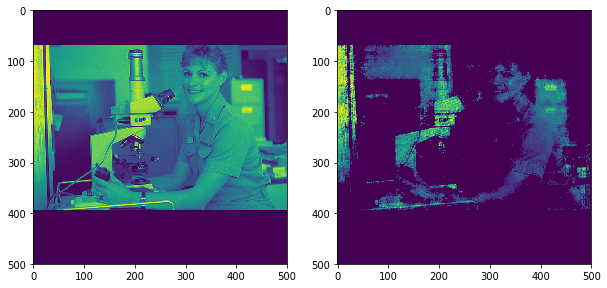

In [48]:
model.eval()
sample = test_data_loader[randint(1, 100)]
rec_img, _, _ = model(sample[0].unsqueeze(0).unsqueeze(0).cuda())

fig=plt.figure(figsize=(10, 10))
columns = 2
rows = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(sample[0].cpu().squeeze(0).squeeze(0).detach().numpy())
fig.add_subplot(rows, columns, 2)
plt.imshow(rec_img.cpu().squeeze(0).squeeze(0).detach().numpy())

plt.show()

## Generate image

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


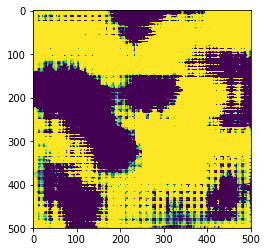

In [51]:
model.eval()
rec_img = model.decode(torch.randn(1, z_dim).cuda())
plt.imshow(rec_img.cpu().squeeze(0).squeeze(0).detach().numpy())

In [0]:
text_inp = ' '.join([item for sublist in word_description[train_img_names[0]] for item in sublist])
prep_text = text_to_idx(text_inp, vocab, lemmatizer)